# Unsupervised learning (K-Means algorithm) Using SKLearn

Following is the algorithm

Choose K random points as cluster centers or cluster means.
For all the N data points: Assign each data point “xi” to one of the K clusters – i.e that cluster whose center is closest to the data point
For K clusters repeat
            C(i) = arg min ||xi – mk||2, i = 1,….,N

Update the cluster center by taking the average of points within cluster.
Repeat above two steps until converge or clusters mean doesn’t change.

# Import packages we need

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import pandas as pd
import glob
import statistics
from sklearn.metrics import pairwise_distances

# Data preparation

We combine the test and train into one larger dataset. The train should be 60,000 records and the test is 10,000 records so your overall dataset should be 70,000 records.

Next step is to break apart the labels and the respective data. Since the pictures are 28x28 (28^2=784) we have 70,000 rows by 785 columns with one being the label (0-9).

In [2]:
training_data = pd.read_csv("https://rapids-keerthi.s3-us-west-1.amazonaws.com/fashion-mnist_train.csv")

In [3]:
test_data = pd.read_csv("https://rapids-keerthi.s3-us-west-1.amazonaws.com/fashion-mnist_test.csv")

Let us see how many data points are there in each

In [4]:
print(training_data.shape[0],"rows of data and",training_data.shape[1],"columns in the training dataset")
print(test_data.shape[0],"rows of data and",test_data.shape[1],"columns in the testing dataset")

60000 rows of data and 785 columns in the training dataset
10000 rows of data and 785 columns in the testing dataset


## Since this is unsupervised learning, we don't need a traditional test/train split, we are going to merge the two datasets to get a larger dataset!

Combine train/test x data, change this to account for both training and testing

In [5]:
combined_dataset = training_data.append(test_data)

print(combined_dataset.shape[0],"rows of data and",combined_dataset.shape[1],"columns in the combined_dataset dataset")

70000 rows of data and 785 columns in the combined_dataset dataset


In [6]:
#Combine train/test y data, change this to account for both training and testing
combined_labels = combined_dataset["label"]
combined_labels=combined_labels.to_frame("labels")
combined_dataset = combined_dataset.drop(['label'], axis=1)

print("labels shape dimension is:",combined_labels.shape)
print("combined dataset without labels dimension is:",combined_dataset.shape)

labels shape dimension is: (70000, 1)
combined dataset without labels dimension is: (70000, 784)


In [7]:
#Build dictionary of labels
labels_dictionary = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

#Grab the keys from the dictionary, to print corresponding value call dict[key]
for i in labels_dictionary:
    print(i,"corresponds with",labels_dictionary[i])

#We can check if a key is in the dictionary quite easily by using the in operator to test membership
#Python has string multiplcation defined, it just concatenates and copies n copies of the string where n is your integer to 
#multiply by
print("-"*100)
if "Leather jacket" in labels_dictionary:
    print("Found it!")
else:
    print("Leather Jacket was not in dictionary")

0 corresponds with T-shirt/top
1 corresponds with Trouser
2 corresponds with Pullover
3 corresponds with Dress
4 corresponds with Coat
5 corresponds with Sandal
6 corresponds with Shirt
7 corresponds with Sneaker
8 corresponds with Bag
9 corresponds with Ankle boot
----------------------------------------------------------------------------------------------------
Leather Jacket was not in dictionary


Lets see what percentage of the dataset corresponds to each article of clothing for each of the labels.  For example if bags had 2000 pictures in the dataset we would say that 2000/70000 ~= 2.85% of the dataset were bags.  Lets print a histogram with your answer.

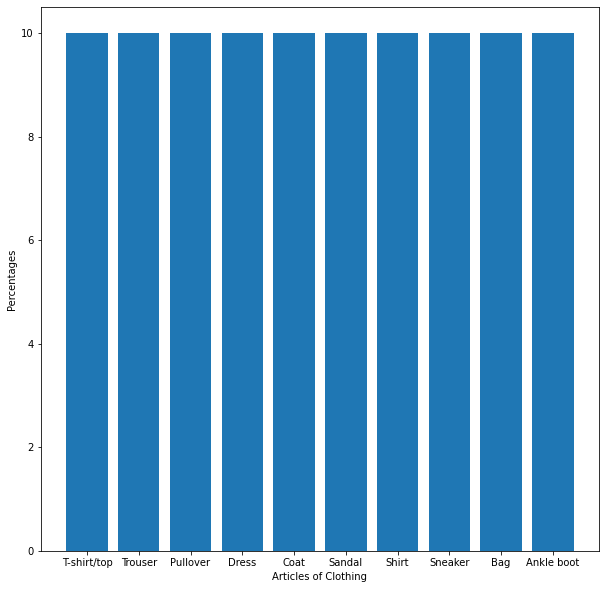

In [10]:
#Plot a histogram here
types_of_clothes = []
plt.figure(figsize=(10,10))
for x in labels_dictionary :
    types_of_clothes.append(labels_dictionary[x])

percentages = combined_labels['labels'].value_counts(normalize=True)*100
names = list(labels_dictionary.values())
plt.bar(names,percentages) 

plt.xlabel("Articles of Clothing") 
plt.ylabel("Percentages") 
plt.show()


Let's plot a random image from our data for each of the class labels.  I've setup the code to plot a random image from the overall dataset, you'll need to **randomly** obtain one of each image type.

In [11]:
def plotImage(data,label,random_number):
    print("Plotting image at index:",random_number)
    clothing_article_index = label.iloc[random_number][0]
    clothing_article = labels_dictionary[clothing_article_index]
    print("This image is a:",clothing_article)
    #Unncessary if data is properly shaped, but this will handle if it isn't
    
    image = np.array(data.iloc[random_number])
    image_reshaped = image.reshape(28,-1)
    
    #load image in grayscale (not to be confused with Game of Thrones greyscale)
    plt.imshow(image_reshaped,cmap="gray") 
    plt.show()  # show the window

 Printing randomly selected image
Plotting image at index: 3830
This image is a: Ankle boot


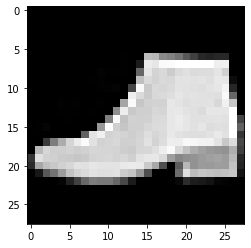

-------------------------------------------------------------------------------
 Printing one of each image type  
Plotting image at index: 39524
This image is a: Shirt


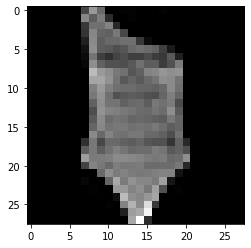

Plotting image at index: 24021
This image is a: Bag


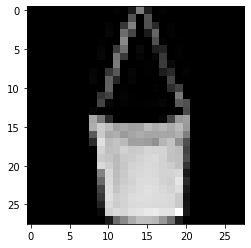

Plotting image at index: 56005
This image is a: Sandal


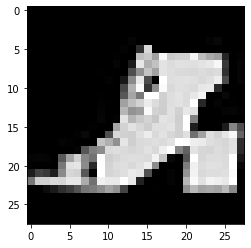

Plotting image at index: 28606
This image is a: Trouser


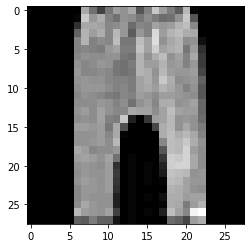

Plotting image at index: 45698
This image is a: Coat


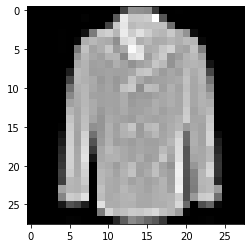

Plotting image at index: 38593
This image is a: Dress


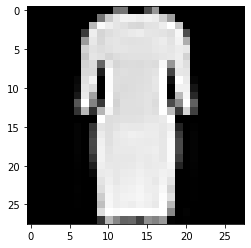

Plotting image at index: 59035
This image is a: T-shirt/top


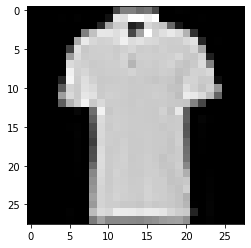

Plotting image at index: 56016
This image is a: Pullover


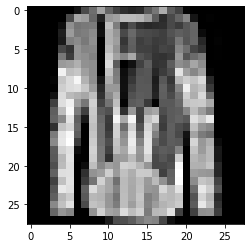

Plotting image at index: 37245
This image is a: Sneaker


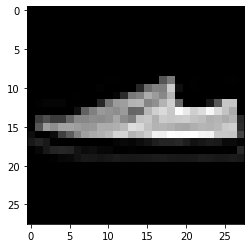

In [12]:
# Example let's plot a random image

#Assign combined_dataset to your data 
print (" Printing randomly selected image")
random_index = random.randint(0,len(combined_dataset)-1)
type_of_garment_initial = labels_dictionary[combined_labels.iloc[random_index][0]] # first type of garment
plotImage(combined_dataset,combined_labels,random_index)


print(79*'-')
print (" Printing one of each image type  ")
type_of_garment = []
selected_garment = []
already_picked_garments = [type_of_garment_initial]

for i in range(0,100):
    random_index = random.randint(0,len(combined_dataset)-1)
    selected_garment=labels_dictionary[combined_labels.iloc[random_index][0]]    
    if (selected_garment not in  already_picked_garments):
        plotImage(combined_dataset,combined_labels,random_index)
        already_picked_garments.append(selected_garment)



Run K-means on your overall data.  Choose ten for your number of clusters.

In [13]:
num_rows = combined_dataset.shape[0]

In [14]:
%%time
num_clusters=10
#precompute_distances=True
k_means = KMeans(n_clusters=num_clusters, n_jobs=-1,random_state=42,precompute_distances=True).fit(combined_dataset)

/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:932: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


CPU times: user 1min 35s, sys: 1.03 s, total: 1min 36s
Wall time: 29.4 s


# Plot a histogram of the number of different items associated with each cluster with our 10 clusters  We merely want the count of each items within each cluster.  

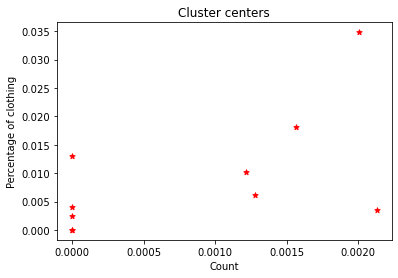

In [15]:
cluster_labels = k_means.labels_
y_kmeans = k_means.predict(combined_dataset)
kmeans_centers= k_means.cluster_centers_


x_centers_values = kmeans_centers[:,0]
y_centers_values = kmeans_centers[:,1]
plt.scatter(x_centers_values,y_centers_values,marker='*',s=30,color='red')
plt.xlabel("Count")
plt.ylabel("Percentage of clothing")
plt.title("Cluster centers")
plt.show()